In [1]:
import numpy as np
import pandas as pd
from dowhy import CausalModel
import graphviz
import warnings
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
# EconML imports
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')




In [2]:
data = pd.read_excel("data.xlsx")

In [3]:
data.columns

Index(['CDD65', 'DBT', 'IECC_CLIMATE', 'WSF', 'HHAGE', 'MONEYPY', 'NHSLDMEM',
       'COOLTYPE', 'AGECENAC', 'WWACAGE', 'NUMBERAC', 'TYPEHUQ', 'ATTIC',
       'ATTICFIN', 'PRKGPLC1', 'STUDIO', 'WALLTYPE', 'ROOFTYPE', 'WINDOWS',
       'YEARMADERANGE', 'TOTROOMS', 'TOTAREA', 'TOTCAREA', 'CELLAR', 'STORIES',
       'OA_LAT', 'ADQINSUL', 'ATTCCOOL', 'BASECOOL', 'TEMPHOMEAC',
       'TEMPGONEAC', 'TEMPNITEAC', 'USECENAC', 'USEWWAC', 'SOLAR', 'THERMAIN',
       'PROTHERM', 'AUDIT', 'AUDITCHG', 'ESWIN', 'SMARTTHERM', 'ELPAY',
       'SMARTMETER', 'INTDATA', 'ENERGYASST', 'SOLOTHER', 'KWHCOL', 'EUI',
       'TEMPNITEAC-TEMPHOMEAC', 'TEMPNITEAC-TEMPGONEAC', 'Home_vs_Night',
       'Gone_vs_Night', 'CDD_category', 'Income_category', 'NHSLDMEM_category',
       'AGECENAC_category', 'WWACAGE_category'],
      dtype='object')

In [4]:
data_for_causal = data[['CDD_category','IECC_CLIMATE','WSF','NHSLDMEM_category','Income_category','COOLTYPE','AGECENAC_category','THERMAIN','Home_vs_Night','Gone_vs_Night','USECENAC','TYPEHUQ','ROOFTYPE',
                        'WALLTYPE','WINDOWS','YEARMADERANGE','TOTROOMS','TOTAREA','TOTCAREA','OA_LAT','ADQINSUL','AUDIT','ESWIN','ELPAY','SMARTMETER','INTDATA','ENERGYASST','SOLOTHER','EUI']]

In [6]:
ac_usage = data_for_causal.copy()
ac_usage = ac_usage.loc[(ac_usage['AGECENAC_category'] != -2)]
ac_usage["AGECENAC_category"] = ac_usage['AGECENAC_category'].replace([0,1], ["< 15", ">= 15"])
ac_usage.groupby(['AGECENAC_category'])['EUI'].count()

AGECENAC_category
< 15     2870
>= 15     799
Name: EUI, dtype: int64

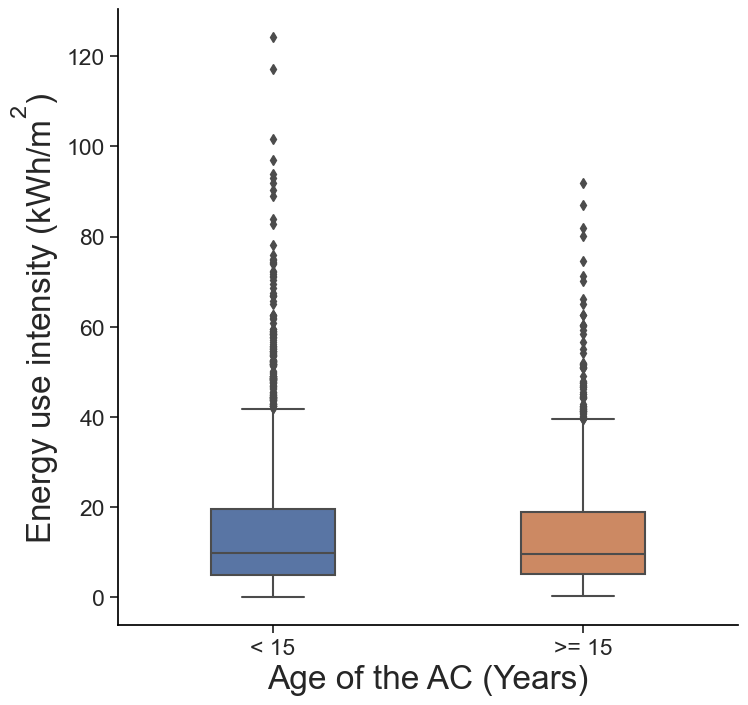

In [8]:
# PROPS = {
#     'boxprops':{'facecolor':'none', 'edgecolor':'black'},
#     'medianprops':{'color':'black'},
#     'whiskerprops':{'color':'black'},
#     'capprops':{'color':'black'}
# }

plt.figure(figsize=(8,8))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.5)
plt.rcParams["axes.edgecolor"] = "black"
# draw = sns.violinplot(x = temp['IECC_CLIMATE'], y = temp['KWHCOL'], hue=temp['TEMP_CHANGE'])
draw = sns.boxplot(x = ac_usage['AGECENAC_category'], y = ac_usage['EUI'], width=0.4)
draw.set_xlabel("Age of the AC (Years)",fontsize=24)
draw.set_ylabel("Energy use intensity (kWh/$\mathregular{m^2}$)",fontsize=24)
# draw.set(ylim=(0, 25000))
figure = draw.get_figure()
figure.savefig('age_of_acr.png', bbox_inches='tight', dpi=300)

In [32]:
filtered_data = ac_usage.loc[(ac_usage['USECENAC'] == 3) | (ac_usage['USECENAC'] ==4)]
filtered_data["USECENAC"] = filtered_data['USECENAC'].replace([3, 4], [0, 1])
filtered_data.groupby(['USECENAC'])['EUI'].count()

USECENAC
0    710
1    421
Name: EUI, dtype: int64

In [33]:
# Initializing causal model
model = CausalModel(data=filtered_data,
                     graph=G.source.replace("\t", ' ').replace("\n", ' '),
                     treatment="USECENAC",
                     outcome="EUI")

# Identifying the estimation method
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
───────────(E[EUI|INTDATA,TOTCAREA,IECC_CLIMATE,AUDIT,OA_LAT,ENERGYASST,THERMA
d[USECENAC]                                                                   

                                                                              
IN,WALLTYPE,ESWIN,TOTROOMS,TOTAREA,ADQINSUL,ROOFTYPE,SOLOTHER,ELPAY,AGECENAC_c
                                                                              

                                                                              
ategory,TYPEHUQ,NHSLDMEM_category,YEARMADERANGE,WINDOWS,CDD_category,WSF,Incom
                                                                              

                                
e_category,SMARTMETER,COOLTYPE])
                                
Estimand assumption 1, Unconfoundedness: If U→{USECENAC} and U→EUI then P(EUI|USECENAC,INTD

In [34]:
random_state = 120
dml_estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                     target_units = 'ate',
                                     confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(random_state=random_state, learning_rate=0.0001),
                                                              'model_t': GradientBoostingRegressor(random_state=random_state, learning_rate=0.0001),
                                                              "model_final":LassoCV(fit_intercept=False, random_state=random_state),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True),
                                                              'random_state':random_state},
                                               "fit_params":{}})
print(dml_estimate.value)

-1.0676535556379223


In [35]:
# dml_estimate.test_stat_significance()

In [36]:
# Random cause
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause", random_seed=random_state)
print(res_random)

# Add Unobserved Common Causes
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02, random_seed=random_state)
print(res_unobserved)

# Placebo Treatment
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", random_seed=random_state)
print(res_placebo)


# Data Subsets Validation
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10, random_seed=random_state)
print(res_subset)

# # Boostrap Validation
# res_bootstrap=model.refute_estimate(identified_estimand, dml_estimate,
#         method_name="bootstrap_refuter", random_seed=random_state)
# print(res_bootstrap)

Refute: Add a random common cause
Estimated effect:-1.0676535556379223
New effect:-1.0675273234569955
p value:0.28

Refute: Add an Unobserved Common Cause
Estimated effect:-1.0676535556379223
New effect:-1.065588646341737

Refute: Use a Placebo Treatment
Estimated effect:-1.0676535556379223
New effect:0.0
p value:1.0

Refute: Use a subset of data
Estimated effect:-1.0676535556379223
New effect:-0.9756125156470608
p value:0.43172401190366955

